In [1]:
from imdb import IMDb
import pandas as pd
import numpy as np
import tmdbsimple as tmdb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import linregress

tmdb.API_KEY = 'efca6d2510906bd92e1f9d6955c5ca9b'
ia = IMDb()


Querry the tmdb and imdb websites to retrive each movies rating according to the larger sample size. Some movies were not found accrding to the provided links. NaN values placed for those movies.

tmdb - utilize the api and retreive wach movie's rating and genere
tmdb - utilize the python library IMDb which just make a get request to the website and reads the json data on the webpage

In [3]:
def makeRequestTMDB(movieID):
    try:
        response = tmdb.Movies(movieID).info()
        rating = response['vote_average']/2 #make the raing out of 5 to match dataset
        genre = ''
        g = response['genres'][:]
        for gen in g:
            genre+=gen['name']+'|'
        
        genre = genre[:-1]
        # print("The rating is: {}".format(rating))
        # print("The genres are: {}".format(genre))
        return rating,genre
    except:
        return np.NaN,np.NaN
    
#print(makeRequestTMDB(19199129)) 

In [4]:

def makeRequestIMDB(movieID):
    try:
        matrix = ia.get_movie(movieID)
        rating = matrix['rating']/2
        g =   matrix['genres']
        genre = ''
        for gen in g:
            genre+=gen+'|'
        
        genre = genre[:-1]
        # print("The rating is: {}".format(rating))
        # print("The genres are: {}".format(genre))
    
        return rating,genre
    except:
        return np.NaN,np.NaN
    
#print(makeRequestIMDB(292923))

In [3]:
links = pd.read_csv("links.csv",delimiter=",",header=0)

links['imdb_rating'], links['imdb_genre'] = zip(*links['imdbId'].map(makeRequestIMDB))
links['tmdb_rating'], links['tmdb_genre'] = zip(*links['tmdbId'].map(makeRequestTMDB))
links.to_csv('links_extraQuery.csv',index=False)



NameError: name 'makeRequestIMDB' is not defined

Read all available data into Pandas DataFrames. Pandas provide functionality that is fast and usefull in statistical analysis.

In [5]:
links2 = pd.read_csv("links_extraQuery.csv", delimiter=",", header=0)
links2.tail(10)

,movieId,imdbId,tmdbId,imdb_rating,imdb_genre,tmdb_rating,tmdb_genre
9732,193565,1636780,71172.0,3.80,Animation|Action|Comedy|History|Sci-Fi,4.05,Action|Comedy|Science Fiction|Animation
9733,193567,2323836,255413.0,3.70,Animation|Adventure|Drama|Family|Fantasy|Myste...,3.60,Animation|Drama
9734,193571,3110014,297825.0,3.35,Comedy|Drama|Romance,3.40,Drama|Comedy
9735,193573,3837248,333623.0,3.55,Animation|Comedy|Music,3.85,Animation|Music
9736,193579,5342766,360617.0,3.25,Documentary,3.95,Documentary
9737,193581,5476944,432131.0,3.80,Animation,3.95,Action|Comedy|Fantasy|Animation
9738,193583,5914996,445030.0,3.75,Animation|Adventure|Comedy|Drama|Fantasy|Romance,3.75,Fantasy|Comedy|Animation
9739,193585,6397426,479308.0,3.00,Drama,3.05,TV Movie|Drama
9740,193587,8391976,483455.0,3.55,Animation,3.95,Animation|Action|Comedy|Mystery
9741,193609,101726,37891.0,2.70,Comedy|Documentary,3.25,Comedy


In [7]:
movies = pd.read_csv("movies.csv",delimiter=",",header=0)
ratings = pd.read_csv("ratings.csv",delimiter=",",header=0)
tags = pd.read_csv("tags.csv",delimiter=",",header=0,parse_dates=True)

print(movies.head(10))
print(ratings.head(10))
print(tags.head(10))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  
6                               Comedy|Romance  
7                           Adventure|Children  
8       

Calculate the average rating of each movie accrding to the MovieLens database

In [8]:

df = ratings.groupby(['movieId']).rating.agg(np.mean).reset_index(name='ave_rating')
df2 = ratings.groupby(['movieId']).size().reset_index(name='counts')
df.merge(df2)


,movieId,ave_rating,counts
0,1,3.920930,215
1,2,3.431818,110
2,3,3.259615,52
3,4,2.357143,7
4,5,3.071429,49
...,...,...,...
9719,193581,4.000000,1
9720,193583,3.500000,1
9721,193585,3.500000,1
9722,193587,3.500000,1


Make a comparison of the rating found on IMDb and TMDb to each user. We calculate how far off each user was from the IMDb and IMDb raing on average for each movie they rated. This is used to calculate the user' sreliablility since the database is still quite small. We did find there are a coupple of users that are outliers, meaning their rating was on average really far off the IMDb and TMDb rating. This can be seen below in the Box plot. The users fallin outside the wiskers are the outliers. A recomendation to remove these users from the study may be beneficial.

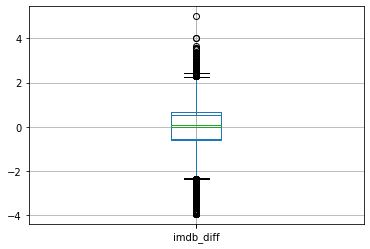

In [9]:
df = ratings.merge(links2, how='left', on='movieId')
df['imdb_diff'] = df['rating'] - df['imdb_rating']
df['tmdb_diff'] = df['rating'] - df['tmdb_rating']
df.boxplot(column=['tmdb_diff'])
df.boxplot(column=['imdb_diff'])
#df.groupby(['userId']).boxplot(column=['tmdb_diff'])
df['imdb_diff_abs'] = df['imdb_diff'].abs()
df['tmdb_diff_abs'] = df['tmdb_diff'].abs()
df1 = df.groupby(['movieId']).imdb_diff_abs.agg(np.mean).reset_index(name='ave_imdb_diff')
df2 = df.groupby(['movieId']).tmdb_diff_abs.agg(np.mean).reset_index(name='ave_tmdb_diff')
df1 = df1.merge(df2)
df3 = df.groupby(['userId']).imdb_diff_abs.agg(np.mean).reset_index(name='ave_imdb_diff')
df4 = df.groupby(['userId']).tmdb_diff_abs.agg(np.mean).reset_index(name='ave_tmdb_diff')
df3 = df3.merge(df4)
df5 = df.groupby(['userId']).imdb_diff.agg([('MinRating_imdb_diff',np.min),('MaxRating_imdb_diff',np.max)])
df6 = df.groupby(['userId']).tmdb_diff.agg([('MinRating_tmdb_diff',np.min),('MaxRating_tmdb_diff',np.max)])



Users that should be removed reside at the top of these two DataFrames. (We did not remove any users since the assignment asked us to work with this dataset)

In [15]:
df7 = df3.sort_values(by=['ave_imdb_diff'], ascending=False)
df8 = df3.sort_values(by=['ave_tmdb_diff'], ascending=False)
df7.head()
#we should therefore trust these users less as the rating on IMDB and TMDB come from a larger population


,userId,ave_imdb_diff,ave_tmdb_diff
2,3,2.343421,2.330263
441,442,2.240000,2.152500
328,329,1.917391,1.865217
254,255,1.785227,1.715909
307,308,1.761304,1.679386


Average Movie rating according to release year. We graph a scatter plot and a linear regression line for the ratings observed. The least quare correlation coefficient tells us that the data is not very well linearly correlated. Therefore the rating and the release year are not lineary correleted  

linear reg least squares correlation coefficient = -0.15848101192865294


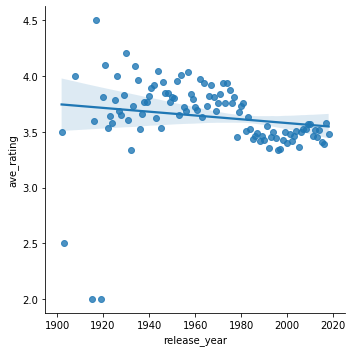

In [11]:
#linear fit
movies['release_year'] = movies['title'].str.extract('(\(\d\d\d\d\))',expand=True)
movies['release_year'] = movies['release_year'].str.extract('(\d\d\d\d)',expand=True)
df = ratings.merge(movies,how='inner',on='movieId')
df1 = df.groupby(['release_year']).rating.agg(np.mean).reset_index(name='ave_rating')
df1['release_year'] = pd.to_numeric(df1['release_year'])
sns.lmplot(x='release_year',y='ave_rating', data=df1,fit_reg=True)

print("linear reg least squares correlation coefficient = {0}".format(linregress(df1['release_year'],df1['ave_rating'])[2]))


We fit a higher degree polinomial to the data which fits the data much better.

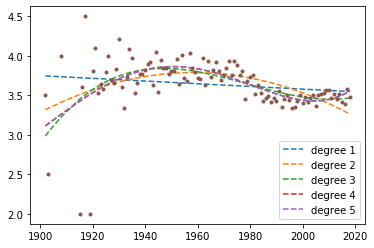

In [12]:
#non linear fit
polinomial_degree = 6
for p in range(1,polinomial_degree):
    z = np.polyfit(df1['release_year'],df1['ave_rating'],p)
    f = np.poly1d(z)
    plt.plot(df1['release_year'],f(df1['release_year']),'--', label='degree {}'.format(p))
plt.plot(df1['release_year'],df1['ave_rating'],'.')
plt.legend()
plt.show()

Calculate the average movie rating per genre. We see that horror films are rated on average lower that all other films and film-noir films are on average rated higher than all other films. There is however not a large difference between the average rating of films based on genres alone.

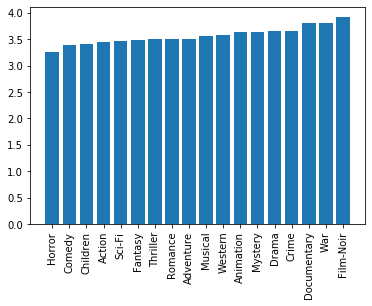

In [13]:

#some genres are not in the documentations - they will be left out of this study

genres = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy',
             'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
df_genres = {}
ave_rating = {}
for g in genres:
    df_genres[g] = movies[movies['genres'].str.contains(g,case=True)]
    df_genre = ratings.merge(df_genres[g],how='inner',on='movieId')
    ave_rating[g] = df_genre['rating'].aggregate(np.mean)

ave_rating = {k: v for k, v in sorted(ave_rating.items(), key=lambda item: item[1])}
plt.bar(ave_rating.keys(),ave_rating.values())
plt.xticks(rotation=90)
plt.show()


